In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
sensor_data = np.load('data/sensor_data.npy') # car sensors
input_keys = pd.read_json('data/input_keys.json') # physical input
car_data = np.load('data/car_data.npy') # Steering(l=-1, f=0, r=1), velocity, velocity_x, velocity_y

In [202]:
print(len(sensor_data), len(input_keys), len(car_data))

9013 9012 9012


In [203]:
car_data = pd.DataFrame(car_data, columns=['steer', 'velocity', 'velocity_x', 'velocity_y'])

In [172]:
car_data['steer'] = abs((car_data['steer'] - 1)/(1 -(-1)))
car_data['velocity'] = (car_data['velocity'] - 0)/(40 -(-0))
car_data['velocity_x'] = abs((car_data['velocity_x'] - (-40))/(40 -(-40)))
car_data['velocity_y'] = abs((car_data['velocity_y'] - (-40))/(40 -(-40)))

In [204]:
input_keys = pd.DataFrame(input_keys)

In [205]:
# input_keys = input_keys.drop(columns=112) # remove record button
input_keys = input_keys.fillna(0)
input_keys = input_keys.rename(columns={119:'W',97:'A',100:'D'})

In [206]:
# color_map:
# road: (0, 0, 0)
# line: (254, 254, 254)
# grass: (0, 188, 0)

# steer:-1(L)  0(F)  1(R)

In [207]:
mapped_data = np.zeros(shape=len(sensor_data), dtype='uint8')

In [208]:
# map pixel to class (r-r     r-l.    r-g.     l-r.     g-r)  
for k,i in enumerate(sensor_data):
    if np.array_equal(i,[[0,0,0],[0,0,0]]):
        mapped_data[k] = 1
    elif np.array_equal(i,[[0,0,0],[254, 254, 254]]) or np.array_equal(i,[[0,0,0],[255,255,255]]) or np.array_equal(i,[[0,0,0],[254,255,254]]):
        mapped_data[k] = 2
    elif np.array_equal(i,[[0,0,0],[0, 188, 0]]):
        mapped_data[k] = 3
    elif np.array_equal(i,[[254, 254, 254],[0, 0, 0]]) or np.array_equal(i,[[255,255,255],[0,0,0]]) or np.array_equal(i,[[254,255,254],[0,0,0]]):
        mapped_data[k] = 4
    elif np.array_equal(i,[[0, 188, 0],[0, 0, 0]]):
        mapped_data[k] = 5

In [209]:
np.unique(mapped_data)

array([1, 2, 3, 4, 5], dtype=uint8)

In [210]:
sensors = pd.DataFrame(columns=['RR','RL','RG','LR','GR'])

In [211]:
for k,d in enumerate(mapped_data):
    if d == 1:
        sensors.at[k,'RR'] = 1
    elif d == 2:
        sensors.at[k,'RL'] = 1
    elif d == 3:
        sensors.at[k,'RG'] = 1
    elif d == 4:
        sensors.at[k,'LR'] = 1
    elif d == 5:
        sensors.at[k,'GR'] = 1

In [212]:
sensors = sensors.fillna(0)
sensors = sensors[:-1]

In [213]:
sensors.head()

,RR,RL,RG,LR,GR
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [214]:
len(sensors)

9012

In [215]:
frames = [sensors, car_data]

In [216]:
X = pd.concat(frames, axis=1)

In [217]:
X.head(1500)

,RR,RL,RG,LR,GR,steer,velocity,velocity_x,velocity_y
0,1,0,0,0,0,0.0,0.0,0.000000,-0.000000
1,1,0,0,0,0,0.0,0.0,0.000000,-0.000000
2,1,0,0,0,0,0.0,0.0,0.000000,-0.000000
3,1,0,0,0,0,0.0,0.0,0.000000,-0.000000
4,1,0,0,0,0,0.0,0.0,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...
1495,0,0,0,1,0,0.0,40.0,25.253219,-31.020557
1496,0,0,0,1,0,0.0,40.0,25.253219,-31.020557
1497,0,0,0,1,0,0.0,40.0,25.253219,-31.020557
1498,0,0,0,1,0,0.0,40.0,25.253219,-31.020557


In [218]:
y = input_keys

In [219]:
y.head()

,W,A,D
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [220]:
print(X.shape, y.shape)

(9012, 9) (9012, 3)


In [51]:
# input features:
# X: road-road(1), road-line(2), road-grass(3), line-road(4), grass-road, steer, velocity(0-40), velocity_x, velocity_y
# Y: left-steer, gas-forward, right-steer

# output:
# gas-forward(119), left-steer(97), right-steer(100)

In [221]:
import keras
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam 

# define model
in_shape = (9,) # number of features
model = Sequential()
model.add(Dense(6, input_shape=in_shape, activation="relu"))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu')) 
model.add(Dense(3, activation='sigmoid'))

model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics=['acc']
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_10 (Dense)             (None, 24)                168       
_________________________________________________________________
dense_11 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 39        
Total params: 567
Trainable params: 567
Non-trainable params: 0
_________________________________________________________________


In [222]:
hist = model.fit(X, y, epochs=50, batch_size=16, validation_split=0.20)

Train on 7209 samples, validate on 1803 samples
Epoch 1/50
7209/7209 [==============================] - 1s 97us/step - loss: 0.7339 - acc: 0.9979 - val_loss: 0.7066 - val_acc: 1.0000
Epoch 2/50
7209/7209 [==============================] - 1s 86us/step - loss: 0.6588 - acc: 0.9994 - val_loss: 0.6512 - val_acc: 0.9917
Epoch 3/50
7209/7209 [==============================] - 1s 76us/step - loss: 0.5571 - acc: 0.9893 - val_loss: 0.4875 - val_acc: 0.9845
Epoch 4/50
7209/7209 [==============================] - 1s 76us/step - loss: 0.4161 - acc: 0.9610 - val_loss: 0.3801 - val_acc: 0.9473
Epoch 5/50
7209/7209 [==============================] - 1s 76us/step - loss: 0.3442 - acc: 0.9490 - val_loss: 0.3366 - val_acc: 0.9301
Epoch 6/50
7209/7209 [==============================] - 1s 76us/step - loss: 0.3138 - acc: 0.9431 - val_loss: 0.3165 - val_acc: 0.9362
Epoch 7/50
7209/7209 [==============================] - 1s 81us/step - loss: 0.3030 - acc: 0.9329 - val_loss: 0.3098 - val_acc: 0.9113
Epoch 8

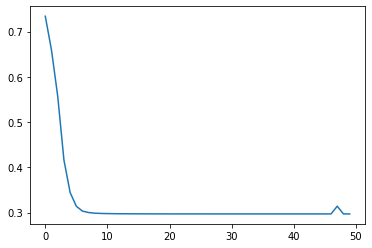

In [223]:
plt.plot(hist.history['loss'])

In [229]:
X[1360:1370]

,RR,RL,RG,LR,GR,steer,velocity,velocity_x,velocity_y
1360,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1361,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1362,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1363,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1364,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1365,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1366,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1367,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1368,0,1,0,0,0,0.0,40.0,16.733038,-36.331879
1369,0,1,0,0,0,0.0,40.0,16.733038,-36.331879


In [230]:
preds=model.predict(X)

In [257]:
preds_ = np.round(preds)

In [259]:
comparison = np.equal(y.values, preds_)

In [267]:
com_cnt = np.all(comparison, axis=1)

In [271]:
un, cnts = np.unique(com_cnt, return_counts=True)

In [274]:
cnts

array([  26, 8986])

In [249]:
with np.printoptions(precision=3, suppress=True):
    print(preds[:2600])

[[0.997 0.    0.   ]
 [0.997 0.    0.   ]
 [0.997 0.    0.   ]
 ...
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]]


In [227]:
# RR   RL   RG   LR   GR   velocity
test = model.predict(np.array([[0,0,0,0,0,0,40,16.733038,-36.331879]]))
# test2 = model.predict(np.array([[0,0,0,0,1,0.8]]))
# test3 = model.predict(np.array([[0,0,1,0,0,0.7]]))
# test4 = model.predict(np.array([[0,1,0,0,0,1]]))
# test5 = model.predict(np.array([[0,0,0,1,0,1]]))

In [228]:
with np.printoptions(precision=3, suppress=True):
    print(test)

[[1. 0. 0.]]


In [332]:
# W   A   D
with np.printoptions(precision=3, suppress=True):
    print(test)
    print(test2)
    print(test3)
    print(test4)
    print(test5)

[[0.784 0.102 0.034]]
[[0.739 0.039 0.037]]
[[0.958 0.244 0.001]]
[[0.916 0.245 0.003]]
[[0.784 0.016 0.021]]


In [256]:
t = np.array(X.values[0])